In [1]:
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
import seaborn as sns
from collections import Counter
import random


In [2]:
train_dir=r'C:\Aswin Thesis\Efficient Detection of Diabetic Retinopathy\SOURCE CODE\Diabetic Retinopathy Detection\model\Dataset\training' 
test_dir=r'C:\Aswin Thesis\Efficient Detection of Diabetic Retinopathy\SOURCE CODE\Diabetic Retinopathy Detection\model\Dataset\testing'


In [3]:
batch_size = 1
epochs = 5
img_height = 224
img_width = 224

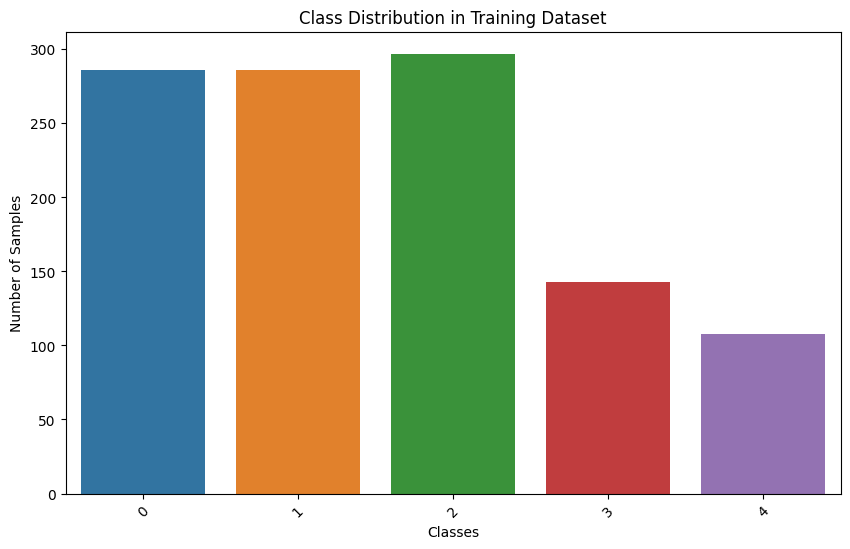

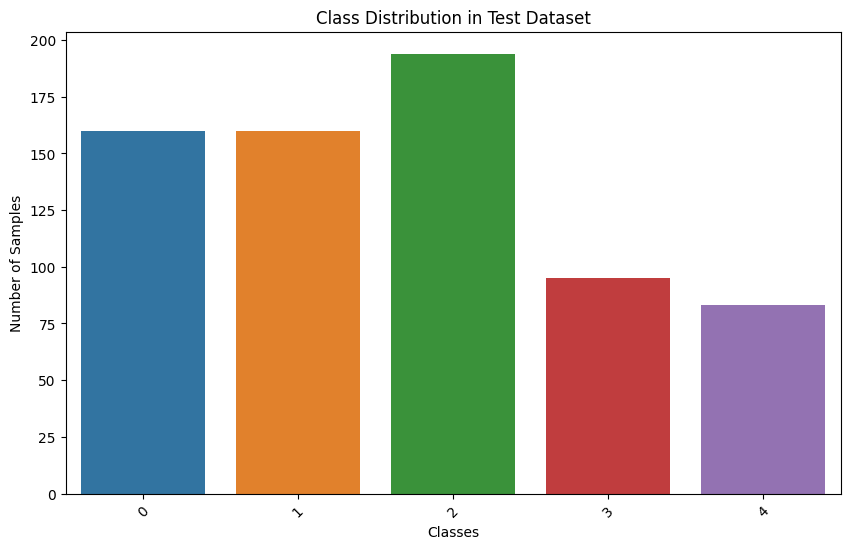

In [5]:
# EDA Section

# Function to count number of images per class
def count_images_in_directory(directory):
    class_counts = {}
    for class_dir in os.listdir(directory):
        class_path = os.path.join(directory, class_dir)
        if os.path.isdir(class_path):
            class_counts[class_dir] = len(os.listdir(class_path))
    return class_counts

# Count images in the training and test sets
train_class_counts = count_images_in_directory(train_dir)
test_class_counts = count_images_in_directory(test_dir)

# Plot the class distributions
def plot_class_distribution(class_counts, dataset_type):
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10,6))
    sns.barplot(x=classes, y=counts)
    plt.title(f'Class Distribution in {dataset_type} Dataset')
    plt.xlabel('Classes')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    plt.show()

# Plot for training and test sets
plot_class_distribution(train_class_counts, 'Training')
plot_class_distribution(test_class_counts, 'Test')



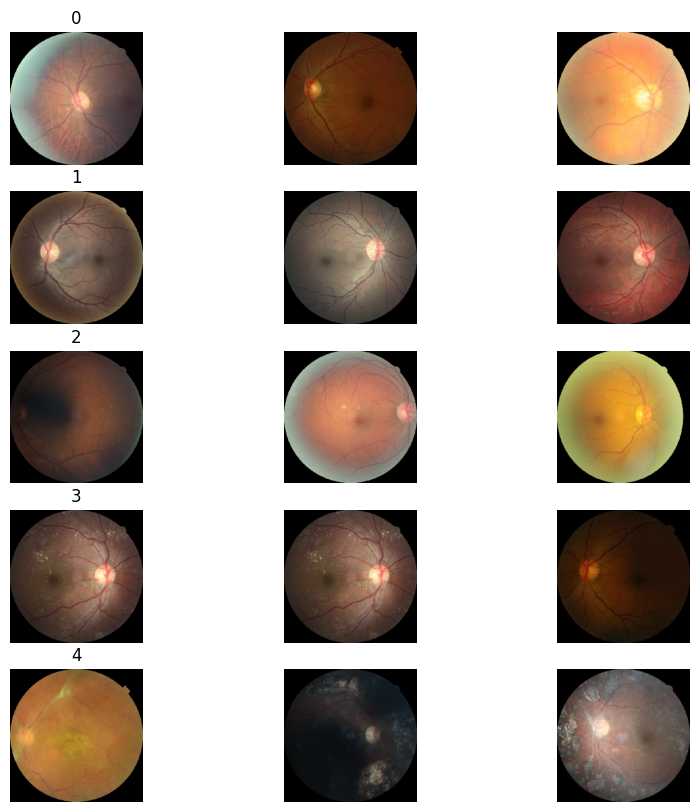

In [15]:

# Visualize Sample Images
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def plot_sample_images(directory, classes, img_height=224, img_width=224, samples_per_class=3):
    fig, axes = plt.subplots(len(classes), samples_per_class, figsize=(10, 10))
    
    for i, class_dir in enumerate(classes):
        class_path = os.path.join(directory, class_dir)
        images = os.listdir(class_path)
        
        for j in range(samples_per_class):
            img_name = random.choice(images)
            img_path = os.path.join(class_path, img_name)
            img = load_img(img_path, target_size=(img_height, img_width))
            img = img_to_array(img) / 255.0
            
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(class_dir)
    
    plt.show()

# Get class names from the training directory
classes = os.listdir(train_dir)

# Plot sample images from the training set
plot_sample_images(train_dir, classes)

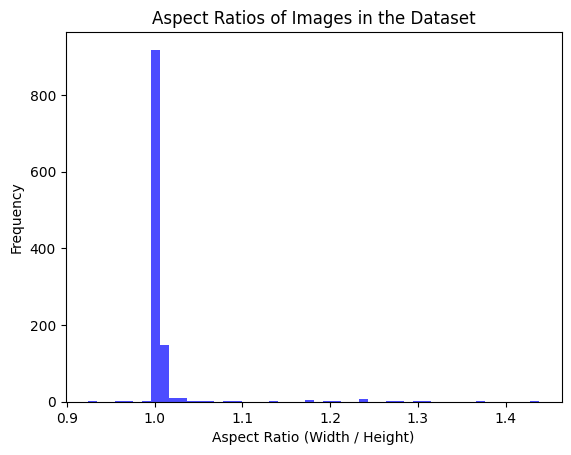

In [16]:
# Analyze Image Shapes and Aspect Ratios
def analyze_image_shapes(directory, classes):
    image_shapes = []

    for class_dir in classes:
        class_path = os.path.join(directory, class_dir)
        images = os.listdir(class_path)

        for img_name in images:
            img_path = os.path.join(class_path, img_name)
            img = load_img(img_path)
            image_shapes.append(img.size)  # (width, height)

    return image_shapes

image_shapes = analyze_image_shapes(train_dir, classes)
image_shapes = np.array(image_shapes)

# Plot aspect ratios
aspect_ratios = image_shapes[:, 0] / image_shapes[:, 1]
plt.hist(aspect_ratios, bins=50, color='blue', alpha=0.7)
plt.title('Aspect Ratios of Images in the Dataset')
plt.xlabel('Aspect Ratio (Width / Height)')
plt.ylabel('Frequency')
plt.show()

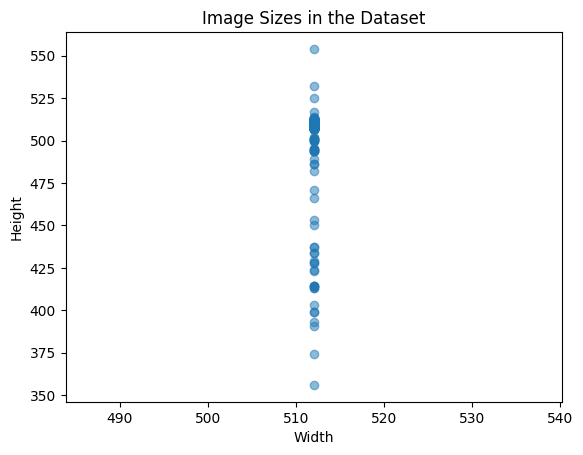

In [17]:
# Plot image sizes
plt.scatter(image_shapes[:, 0], image_shapes[:, 1], alpha=0.5)
plt.title('Image Sizes in the Dataset')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()

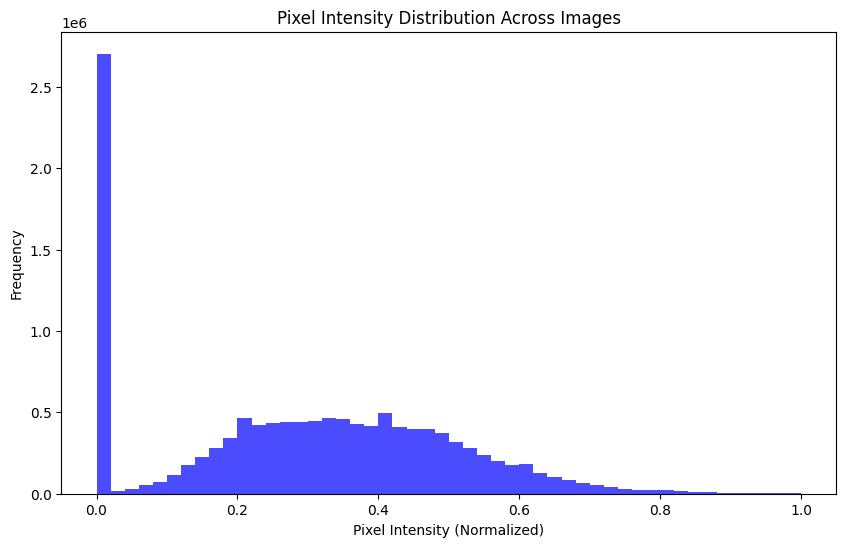

In [18]:
def plot_pixel_intensity_distribution(directory, classes, num_images=50):
    pixel_values = []

    for class_dir in classes:
        class_path = os.path.join(directory, class_dir)
        images = os.listdir(class_path)

        # Collect pixel intensities from a sample of images
        for img_name in images[:num_images]:  # Sample a few images
            img_path = os.path.join(class_path, img_name)
            img = load_img(img_path, target_size=(img_height, img_width), color_mode='grayscale')
            img = img_to_array(img).flatten() / 255.0  # Normalize pixel values
            pixel_values.extend(img)

    # Plot the histogram
    plt.figure(figsize=(10,6))
    plt.hist(pixel_values, bins=50, color='blue', alpha=0.7)
    plt.title('Pixel Intensity Distribution Across Images')
    plt.xlabel('Pixel Intensity (Normalized)')
    plt.ylabel('Frequency')
    plt.show()

# Analyze pixel intensities for training images
plot_pixel_intensity_distribution(train_dir, classes)


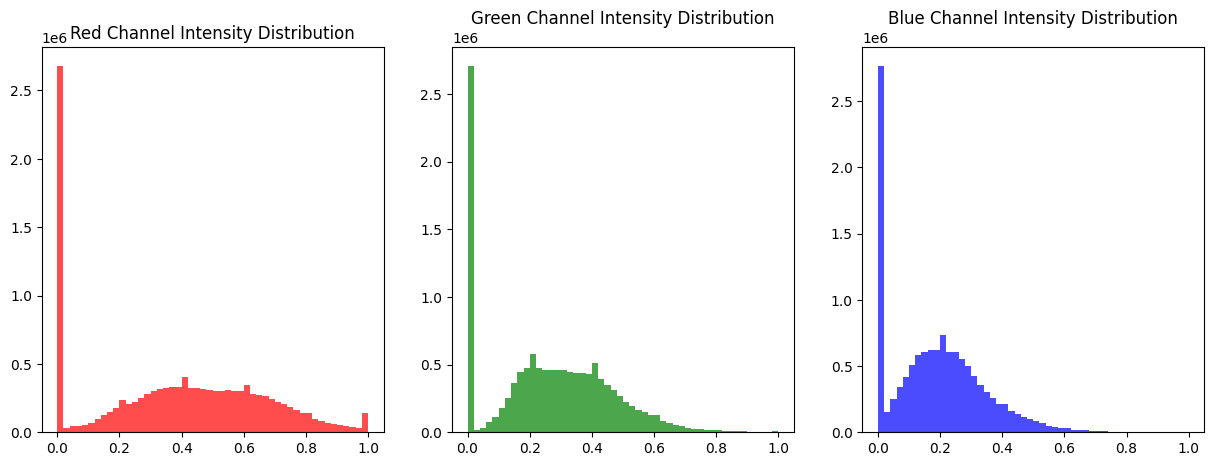

In [19]:
def plot_rgb_channel_distribution(directory, classes, num_images=50):
    red_channel = []
    green_channel = []
    blue_channel = []

    for class_dir in classes:
        class_path = os.path.join(directory, class_dir)
        images = os.listdir(class_path)

        for img_name in images[:num_images]:  # Sample a few images
            img_path = os.path.join(class_path, img_name)
            img = load_img(img_path, target_size=(img_height, img_width))
            img_array = img_to_array(img).astype('float32') / 255.0  # Normalize pixel values
            red_channel.extend(img_array[:, :, 0].flatten())  # Red channel
            green_channel.extend(img_array[:, :, 1].flatten())  # Green channel
            blue_channel.extend(img_array[:, :, 2].flatten())  # Blue channel

    # Plot histograms for each color channel
    plt.figure(figsize=(15,5))
    plt.subplot(1, 3, 1)
    plt.hist(red_channel, bins=50, color='red', alpha=0.7)
    plt.title('Red Channel Intensity Distribution')

    plt.subplot(1, 3, 2)
    plt.hist(green_channel, bins=50, color='green', alpha=0.7)
    plt.title('Green Channel Intensity Distribution')

    plt.subplot(1, 3, 3)
    plt.hist(blue_channel, bins=50, color='blue', alpha=0.7)
    plt.title('Blue Channel Intensity Distribution')

    plt.show()

# Analyze RGB channels for training images
plot_rgb_channel_distribution(train_dir, classes)


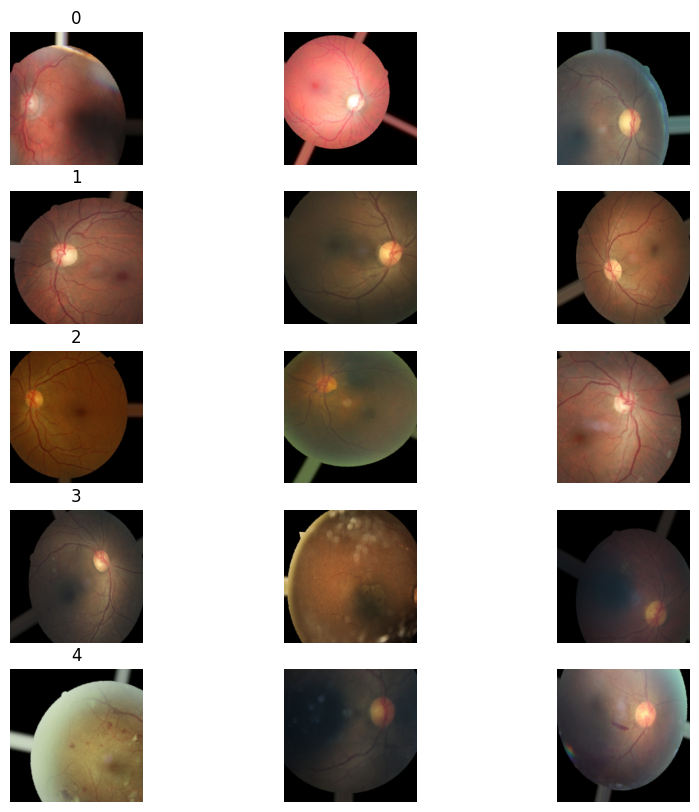

In [20]:
def visualize_augmented_images(data_gen, directory, classes, img_height=224, img_width=224, samples_per_class=3):
    fig, axes = plt.subplots(len(classes), samples_per_class, figsize=(10, 10))

    for i, class_dir in enumerate(classes):
        class_path = os.path.join(directory, class_dir)
        images = os.listdir(class_path)

        for j in range(samples_per_class):
            img_name = random.choice(images)
            img_path = os.path.join(class_path, img_name)
            img = load_img(img_path, target_size=(img_height, img_width))
            img = img_to_array(img) / 255.0

            augmented_img = data_gen.random_transform(img)  # Apply random augmentation

            axes[i, j].imshow(augmented_img)
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(class_dir)

    plt.show()

# Define an image data generator with augmentation
augmented_data_gen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Visualize augmented images
visualize_augmented_images(augmented_data_gen, train_dir, classes)


In [21]:
def calculate_mean_std_per_channel(directory, classes):
    means = np.zeros(3)
    stds = np.zeros(3)
    num_images = 0

    for class_dir in classes:
        class_path = os.path.join(directory, class_dir)
        images = os.listdir(class_path)

        for img_name in images:
            img_path = os.path.join(class_path, img_name)
            img = load_img(img_path, target_size=(img_height, img_width))
            img = img_to_array(img) / 255.0

            means += np.mean(img, axis=(0, 1))
            stds += np.std(img, axis=(0, 1))
            num_images += 1

    means /= num_images
    stds /= num_images

    print(f"Mean per channel: {means}")
    print(f"Standard deviation per channel: {stds}")

# Calculate the mean and standard deviation for the training images
calculate_mean_std_per_channel(train_dir, classes)


Mean per channel: [0.37779536 0.26045484 0.18353424]
Standard deviation per channel: [0.22850083 0.16039101 0.11263551]


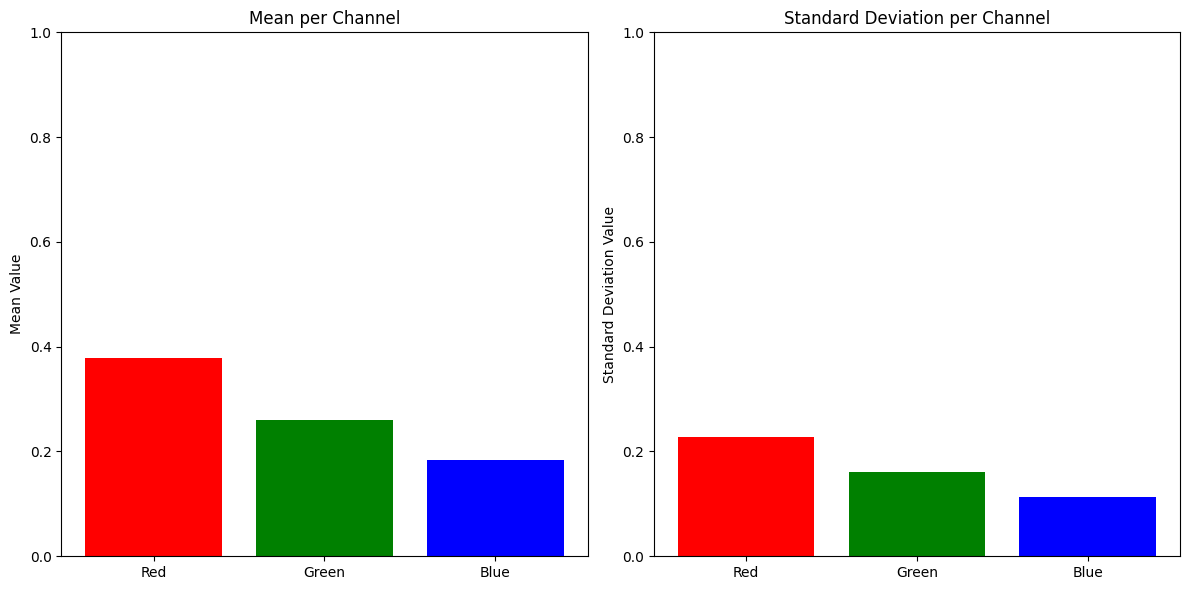

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Example values for the mean and standard deviation (replace with your calculated values)
means = np.array([0.37779536, 0.26045484, 0.18353424])
stds = np.array([0.22850083, 0.16039101, 0.11263551])

# Channel labels (R, G, B)
channels = ['Red', 'Green', 'Blue']

# Create a bar plot for mean and standard deviation
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot Mean per channel
ax[0].bar(channels, means, color=['r', 'g', 'b'])
ax[0].set_title('Mean per Channel')
ax[0].set_ylabel('Mean Value')
ax[0].set_ylim(0, 1)  # Since the pixel values are normalized to [0,1]

# Plot Standard Deviation per channel
ax[1].bar(channels, stds, color=['r', 'g', 'b'])
ax[1].set_title('Standard Deviation per Channel')
ax[1].set_ylabel('Standard Deviation Value')
ax[1].set_ylim(0, 1)  # Since standard deviation is also normalized to [0,1]

plt.tight_layout()
plt.show()


In [23]:
def calculate_overall_stats(directory, classes):
    all_pixels = []

    for class_dir in classes:
        class_path = os.path.join(directory, class_dir)
        images = os.listdir(class_path)

        for img_name in images:
            img_path = os.path.join(class_path, img_name)
            img = load_img(img_path, target_size=(img_height, img_width))
            img = img_to_array(img) / 255.0

            # Flatten the image array and append to the list of all pixels
            all_pixels.append(img.reshape(-1, 3))  # Reshape to (num_pixels, 3) for R, G, B channels

    all_pixels = np.vstack(all_pixels)  # Stack all pixel arrays into one

    # Calculate overall statistics
    overall_mean = np.mean(all_pixels)
    overall_median = np.median(all_pixels)
    overall_std = np.std(all_pixels)

    print(f"Overall Mean: {overall_mean}")
    print(f"Overall Median: {overall_median}")
    print(f"Overall Standard Deviation: {overall_std}")

# Calculate the overall mean, median, and standard deviation for the training images
calculate_overall_stats(train_dir, classes)


Overall Mean: 0.27392786741256714
Overall Median: 0.250980406999588
Overall Standard Deviation: 0.22349335253238678


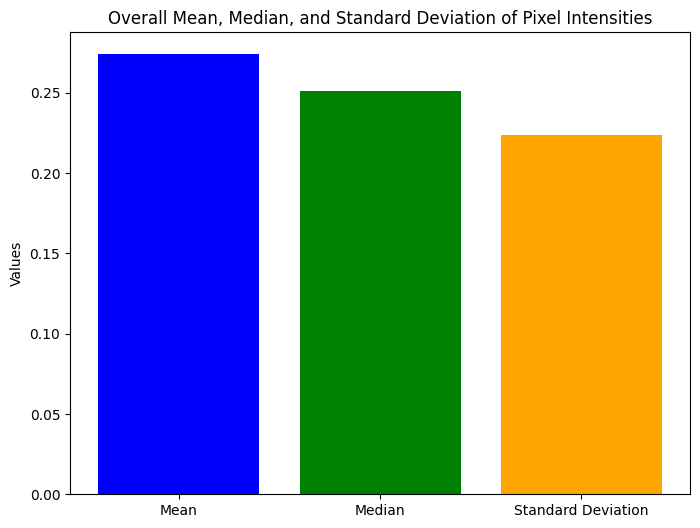

In [24]:
mean = 0.2739
median = 0.2510
std_dev = 0.2235

# Labels and values for the bar plot
labels = ['Mean', 'Median', 'Standard Deviation']
values = [mean, median, std_dev]

# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(labels, values, color=['blue', 'green', 'orange'])

# Add titles and labels
plt.title('Overall Mean, Median, and Standard Deviation of Pixel Intensities')
plt.ylabel('Values')

# Display the plot
plt.show()